In [ ]:
!nvidia-smi

Tue Jul  8 04:16:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [ ]:
filtered_train_data = pd.read_csv("../data/merged_df.csv")

In [ ]:
filtered_train_data.dropna(inplace = True)
filtered_train_data.drop_duplicates(inplace = True)

In [ ]:
print(filtered_train_data.shape)
filtered_train_data.head()

(31520, 7)


,image_id,x,y,width,height,english_text,hindi_text
0,2341043,324,197,44,22,Silver bracelet around woman's neck.,महिला गर्दन के आसपास सिल्वर ब्रेसेलेट
1,2365053,215,242,243,130,piece of sandwich stuff with lot of meat,सैंडविच का भाग बहुत सारे मांस से भड़ा हुआ
2,2380933,0,0,410,497,a black and white picture of a park scene,एक पार्क दृश्य का काला और सफेद चित्र
3,2402778,19,2,166,209,large rectangular mirror over sink,सिंक पर बड़ा आयताकार दर्पण
4,2396975,216,185,237,82,a car loading food on a plane,हवाई जहाज पर खाना भारित करता हुआ वाहन


In [ ]:
# 1. Add <sos> and <eos> tokens
filtered_train_data['en'] = filtered_train_data['english_text'].apply(lambda x: '<sos> ' + ' '.join(str(x).split()[::-1]) + ' <eos>') # reversing the inut sequence
filtered_train_data['hi'] = filtered_train_data['hindi_text'].apply(lambda x: '<sos> ' + str(x) + ' <eos>')

# 2. Tokenization (word level)
en_tokenizer = Tokenizer(num_words=50000, filters='', lower=False)
hi_tokenizer = Tokenizer(num_words=50000, filters='', lower=False)

en_tokenizer.fit_on_texts(filtered_train_data['en'])
hi_tokenizer.fit_on_texts(filtered_train_data['hi'])

en_sequences = en_tokenizer.texts_to_sequences(filtered_train_data['en'])
hi_sequences = hi_tokenizer.texts_to_sequences(filtered_train_data['hi'])

# 3. Padding
max_en_len = max(len(seq) for seq in en_sequences)
max_hi_len = max(len(seq) for seq in hi_sequences)

en_padded = pad_sequences(en_sequences, maxlen=max_en_len, padding='post')
hi_padded = pad_sequences(hi_sequences, maxlen=max_hi_len, padding='post')

In [ ]:
max_en_len , max_hi_len

(27, 33)

In [ ]:
import pickle

pickle.dump([en_tokenizer,hi_tokenizer,max_en_len,max_hi_len] , open("../models/tokenizers_for_english_to_hindi.pkl", "wb"))

In [ ]:
# Define model parameters
embedding_dim = 256
lstm_units = 256
l2_reg = regularizers.l2(1e-4)  # Weight decay strength

# Vocabulary size (from tokenizers)
vocab_size_en = len(en_tokenizer.word_index) + 1  # English vocab
vocab_size_hi = len(hi_tokenizer.word_index) + 1  # Hindi vocab

# --- Encoder ---
encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(
    input_dim=vocab_size_en,
    output_dim=embedding_dim,
    mask_zero=True,
    embeddings_regularizer=l2_reg  # Regularization added here
)(encoder_input)
encoder_lstm = LSTM(
    units=lstm_units,
    return_state=True,
    kernel_regularizer=l2_reg,      # Regularization for kernel
    recurrent_regularizer=l2_reg    # Regularization for recurrent connection
)
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(
    input_dim=vocab_size_hi,
    output_dim=embedding_dim,
    mask_zero=True,
    embeddings_regularizer=l2_reg  # Regularization added here
)(decoder_input)
decoder_lstm = LSTM(
    units=lstm_units,
    return_sequences=True,
    return_state=True,
    kernel_regularizer=l2_reg,      # Regularization for kernel
    recurrent_regularizer=l2_reg    # Regularization for recurrent connection
)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(
    units=vocab_size_hi,
    activation='softmax',
    kernel_regularizer=l2_reg  # Regularization added here
)
decoder_output = decoder_dense(decoder_output)

# --- Define the full model ---
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)

In [ ]:
# Model definition
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,134,784 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  2,225,152 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    525,312 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,233,844 │ lstm_1[0][0]      │
│                     │ 8692)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,644,404 (29.16 MB)

 Trainable params: 7,644,404 (29.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs without improvement
    restore_best_weights=True,
    verbose = 1
)

In [ ]:
# Shift fr_padded to create decoder_target_data (by removing <sos> token or shifting)
decoder_target_data = hi_padded[:, 1:]  # Remove first token
decoder_input_data = hi_padded[:, :-1]  # Remove last token

# Train the model with EarlyStopping
history = model.fit(
    [en_padded, decoder_input_data],           # Input: Encoder + Decoder input
    decoder_target_data[..., np.newaxis],      # Output: Decoder targets
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop]                     # Add callback here
)

Epoch 1/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.3747 - loss: 5.1823 - val_accuracy: 0.0915 - val_loss: 3.9983
Epoch 2/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.0929 - loss: 3.8948 - val_accuracy: 0.1013 - val_loss: 3.6678
Epoch 3/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.1038 - loss: 3.5121 - val_accuracy: 0.1092 - val_loss: 3.3861
Epoch 4/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.1113 - loss: 3.2450 - val_accuracy: 0.1146 - val_loss: 3.2259
Epoch 5/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.1177 - loss: 3.0544 - val_accuracy: 0.1212 - val_loss: 3.0823
Epoch 6/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.1233 - loss: 2.8866 - val_accuracy: 0.1248 - val_loss: 2.9984
Epoch 7/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.1278 - loss: 2.7582 - val_accuracy: 0.1273 - val_loss: 2.9454
Epoch 8/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.1312 - loss: 2

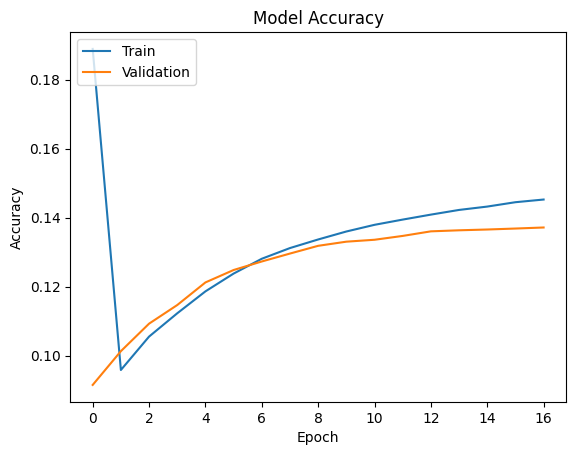

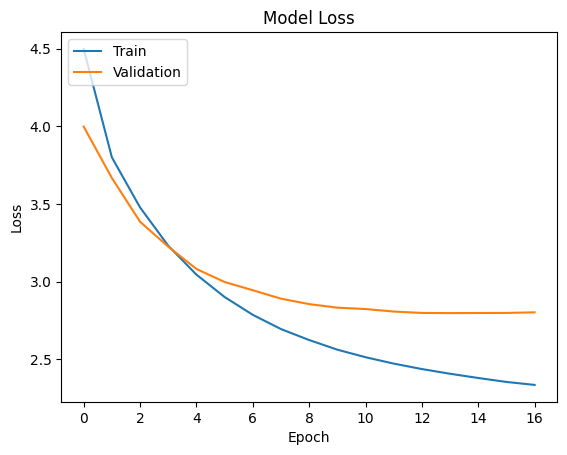

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# en : the wall is brown
# en : this is a man
# en : plane flaying in the sky
# en : edge of a boat

# Inference setup
input_sentence = "<sos> the wall is brown <eos>"

# Convert to sequence
input_seq = en_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_en_len, padding='post')

# Start the decoder input with just <sos>
decoder_input_tokens = [hi_tokenizer.word_index['<sos>']]

# Placeholder for output sentence
decoded_sentence = ''

# Predict tokens step-by-step
for _ in range(max_hi_len):
    # Prepare decoder input
    decoder_input = np.array(decoder_input_tokens).reshape(1, -1)

    # Predict next token
    output_tokens = model.predict([input_seq, decoder_input], verbose=0)
    predicted_token = np.argmax(output_tokens[0, -1, :])

    # Convert token to word
    predicted_word = hi_tokenizer.index_word.get(predicted_token, '')

    if predicted_word == '<eos>':
        break

    decoded_sentence += ' ' + predicted_word

    # Append predicted token to decoder input for next time step
    decoder_input_tokens.append(predicted_token)

# Print final decoded sentence
print(decoded_sentence.strip())

दीवार भूरा है


In [ ]:
# right way to save model using keras
model.save("../models/english_to_hindi_model.keras")

In [ ]:
# how to load model

# from tensorflow.keras.models import load_model
# model = load_model("../models/english_to_hindi_model.keras")